# Extraccion de características
Para comparar imágenes o buscarlas en una base de datos se necesitan características que sean independientes de los colores, cambios de iluminación, escalas, rotaciones y transformaciones afines.

En una imagen habrá zonas de escaso interés (p. ej. interiores sin cambios) y otras de gran interés (p. ej esquinas).
* En una zona de color más o menos uniforme no hay cambios significativos en ninguna dirección.
* En un borde no hay cambios significativos en una dirección.
* En una esquina hay cambios significativos en todas direcciones.

Practical Computer Vision - (Cap. 4) What is a Feature?
https://learning.oreilly.com/library/view/practical-computer-vision/9781788297684/2842a903-f1d7-40f2-97cc-751bd73f5f85.xhtml

OpenCV 3.x with Python By Example - Second Edition - (Cap. 5) Extracting Features from an Image
https://learning.oreilly.com/library/view/opencv-3x-with/9781788396905/96e201d9-501a-4cd4-bb84-b693823c97f5.xhtml

Computer Vision with Python 3 - (Cap. 3) Drilling Deeper into Features - Object Detection  
https://learning.oreilly.com/library/view/computer-vision-with/9781788299763/9162c133-cc35-4a38-a52c-cb11506895db.xhtml
<br> Usa skimage http://scikit-image.org/docs/dev/api/skimage.html

OpenCV Tutorials - Feature Detection and Description
https://docs.opencv.org/3.4.1/db/d27/tutorial_py_table_of_contents_feature2d.html

Este notebook utiliza opencv-contrib-python https://pypi.org/project/opencv-contrib-python/, cuya versión debe ser <= que la de OpenCV que se tenga instalada.

In [1]:
import numpy as np
import cv2

import matplotlib.pyplot as plt
import plot_cv_utils

%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 4.5)

## Detección de esquinas (Harris)
Construir matrices 2x2 a partir de las derivadas parciales de la imagen en niveles de grises y los puntos con autovalores grandes son susceptibles de ser esquinas. Es invariante frente a rotaciones.

Artículo original de Harris y Stephens http://www.bmva.org/bmvc/1988/avc-88-023.pdf

Shi y Tomasi mejoraron el algoritmo http://www.ai.mit.edu/courses/6.891/handouts/shi94good.pdf

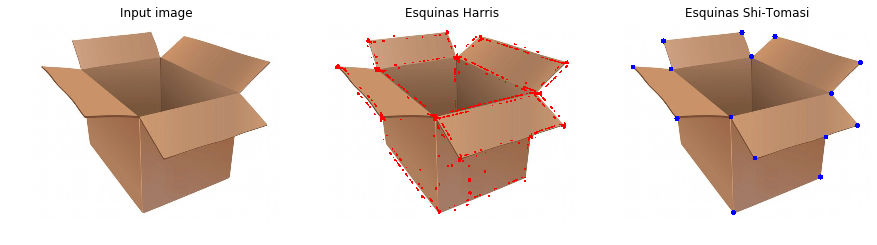

In [2]:
# cambiar entre flower.png y box.jpeg para comparar
# variar el threshold, probar con 0.01 y 0.0000001
threshold = 0.0000001

img_box = cv2.imread('images/box.jpeg') 
gray = cv2.cvtColor(img_box, cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)

dst = cv2.cornerHarris(gray, 4,5, 0.04)      # to detect only sharp corners
#dst = cv2.cornerHarris(gray, 14, 5, 0.04)    # to detect soft corners

# Result is dilated for marking the corners
dst = cv2.dilate(dst,None)

corners_harris_img = img_box.copy()

# Threshold for an optimal value, it may vary depending on the image.
corners_harris_img[dst > threshold*dst.max()] = [0,0,255]

# Mejora de Shi y Tomasi (goodFeaturesToTrack())
corners_shi_tomasi_img = img_box.copy()

top_k = 15 # los k mejores, cambiar para obtener más esquinas, probar con 1000
corners = cv2.goodFeaturesToTrack(gray, top_k, 0.05, 25)
corners = np.float32(corners)

for item in corners:
    x, y = item[0]
    cv2.circle(corners_shi_tomasi_img, (x,y), 5, 255, -1)
    
plot_cv_utils.subplot_cv_list([img_box, corners_harris_img, corners_shi_tomasi_img],
                              ['Input image', 'Esquinas Harris', 'Esquinas Shi-Tomasi'],
                              False, False)    

## SIFT (Scale invariant feature transform)

http://www.vision.ee.ethz.ch/~surf/eccv06.pdf

https://en.wikipedia.org/wiki/Scale-invariant_feature_transform

http://aishack.in/tutorials/sift-scale-invariant-feature-transform-introduction/



* Nota: el algoritmo SIFT es un algoritmo patentado y ha sido retirado de las distribuciones por defecto de las  versiones más recientes de openCV, aunque se puede compilar para que funcione. 
* En la versión opencv-contrib-python==3.4.2.17  está disponible por defecto

### Obtención de puntos claves
Los radios de los círculos indican la fuerza de la característica y la flecha la orientación.

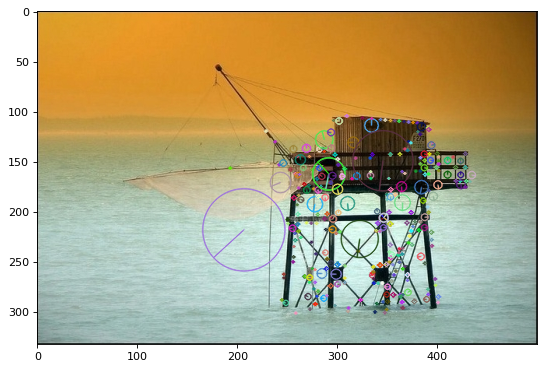

In [6]:
red_image = cv2.imread('figures/red-pesca.jpeg')
red_image_gray = cv2.cvtColor(red_image, cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create() # cv2.SIFT()
keypoints = sift.detect(red_image_gray, None)

red_image_sift_features = cv2.drawKeypoints(red_image, keypoints, None,
                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plot_cv_utils.plot_cv_img_org(red_image_sift_features)

### Emparejamiento de puntos claves en dos imágenes

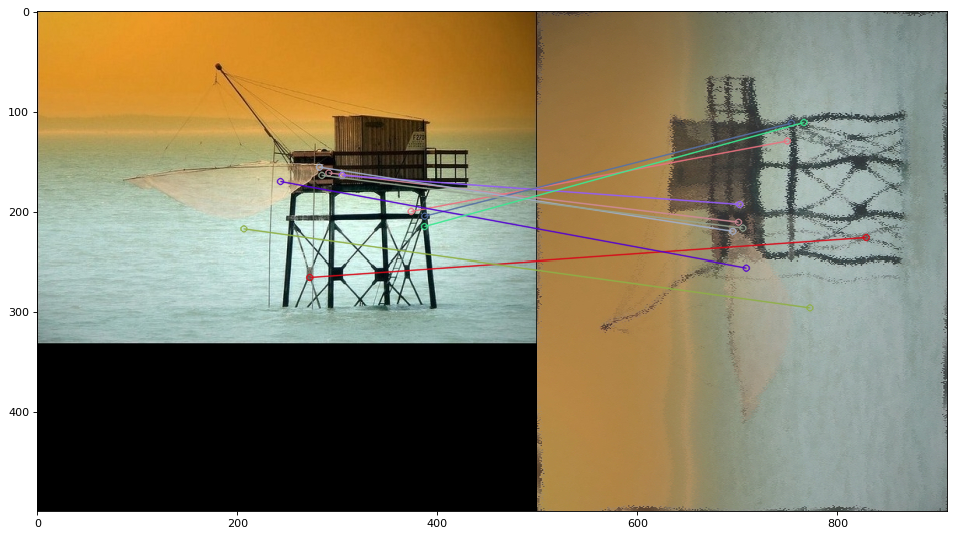

In [7]:
import random

red_image_distort = cv2.imread('images/red-pesca_distort.jpeg')
red_image_gray_distort = cv2.cvtColor(red_image_distort,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()

kp, desc = sift.detectAndCompute(red_image_gray,None)
kp_distort, desc_distort = sift.detectAndCompute(red_image_gray_distort, None)

# Brute Force Matcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc, desc_distort, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.4*n.distance:
        good.append([m])

# Shuffle the matched keypoints, para elegirlos al azar
random.shuffle(good)
# cv2.drawMatchesKnn expects list of lists as matches.
image_match = cv2.drawMatchesKnn(red_image,kp,red_image_distort,
                                 kp_distort,good[:10],flags=2, outImg=None)
plot_cv_utils.plot_cv_img_org(image_match)

## SURF (Speeded Up Robust Features)

http://www.vision.ee.ethz.ch/~surf/eccv06.pdf

https://es.wikipedia.org/wiki/SURF

### Obtención de puntos claves
Los radios de los círculos indican la fuerza de la característica y la línea la orientación.

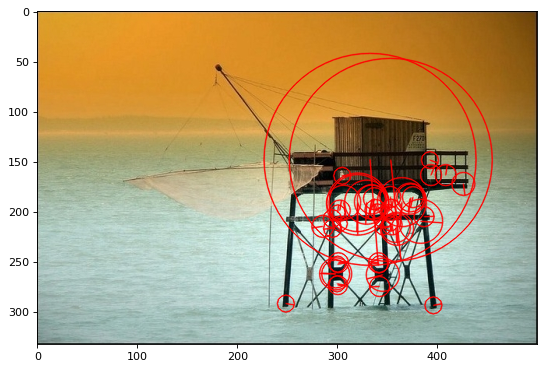

In [8]:
# This threshold controls the number of keypoints
threshold = 15000 # cuanto mayor menos características
surf = cv2.xfeatures2d.SURF_create(threshold)

kp, des = surf.detectAndCompute(red_image_gray, None)

red_image_surf_features = cv2.drawKeypoints(red_image, kp, None, (0,0,255),
                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plot_cv_utils.plot_cv_img_org(red_image_surf_features)

### Emparejamiento de puntos claves en dos imágenes

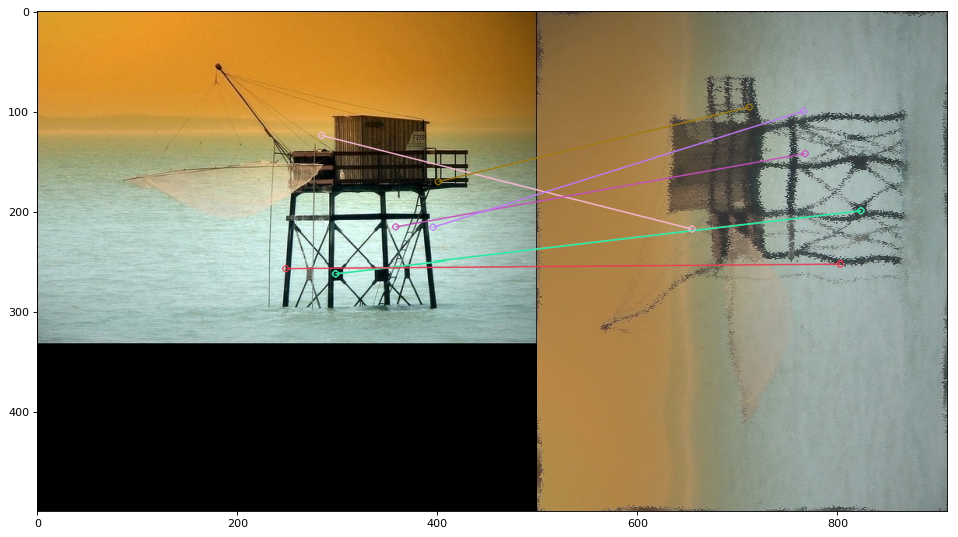

In [9]:
# Si se pone 15000 no se encuentran keypoints en la imagen distorsionada
# y matches = bf.knnMatch(desc, desc_distort, k = 2) da error
# cargar figures/red-pesca_rot.jpeg para comparar
surf = cv2.xfeatures2d.SURF_create(1000)

kp, desc = surf.detectAndCompute(red_image_gray,None)
kp_distort, desc_distort = surf.detectAndCompute(red_image_gray_distort, None)

# Brute Force Matcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc, desc_distort, k = 2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.4*n.distance:
        good.append([m])

# Shuffle the matched keypoints, para elegirlos al azar
random.shuffle(good)
# cv2.drawMatchesKnn expects list of lists as matches.
image_match = cv2.drawMatchesKnn(red_image,kp,red_image_distort,
                                 kp_distort,good[:10],flags=2, outImg=None)
plot_cv_utils.plot_cv_img_org(image_match)

## FAST (Features from Accelerated Segment Test)

http://www.edwardrosten.com/work/rosten_2006_machine.pdf

https://en.wikipedia.org/wiki/Features_from_accelerated_segment_test

### Obtención de puntos claves
Los círculos indican la característica.

Total Keypoint 111


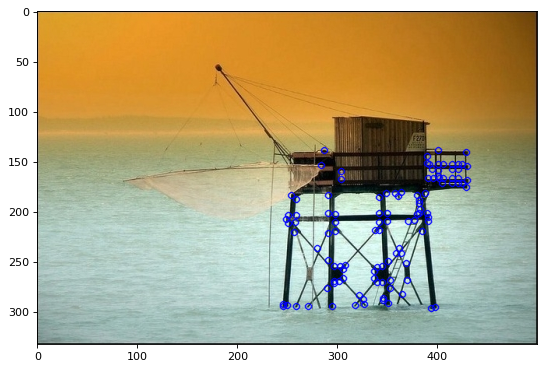

In [10]:
# Initiate FAST object with default values
# cambiar valores para ver resultado
threshold = 100
nonmaxSuppression = True
neighborhood = 2
fast = cv2.FastFeatureDetector_create(threshold, nonmaxSuppression, neighborhood)

# find and draw the keypoints
kp = fast.detect(red_image_gray,None)
red_image_fast_features = cv2.drawKeypoints(red_image, kp,  None, color=(255,0,0))

# Número total de puntos claves
print( "Total Keypoint {}".format(len(kp)) )

plot_cv_utils.plot_cv_img_org(red_image_fast_features)

## ORB (Oriented FAST and Rotated BRIEF)

http://www.willowgarage.com/sites/default/files/orb_final.pdf

### Obtención de puntos claves
Los radios de los círculos indican la fuerza de la característica y la línea la orientación.

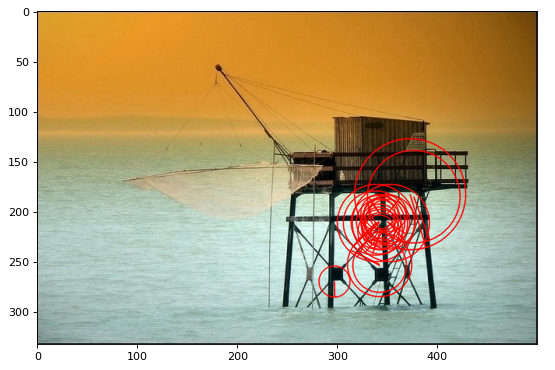

In [11]:
# Initiate ORB detector
nFeatures = 20
orb = cv2.ORB_create(nFeatures)

# find the keypoints with ORB
kp1 = orb.detect(red_image_gray, None)
# compute the descriptors with ORB
kp1, des1 = orb.compute(red_image_gray, kp1)

# draw only keypoints location,not size and orientation
red_image_org_features = cv2.drawKeypoints(red_image, kp1, None, color=(0,0,255),
                        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plot_cv_utils.plot_cv_img_org(red_image_org_features)

### Emparejamiento de puntos claves en dos imágenes

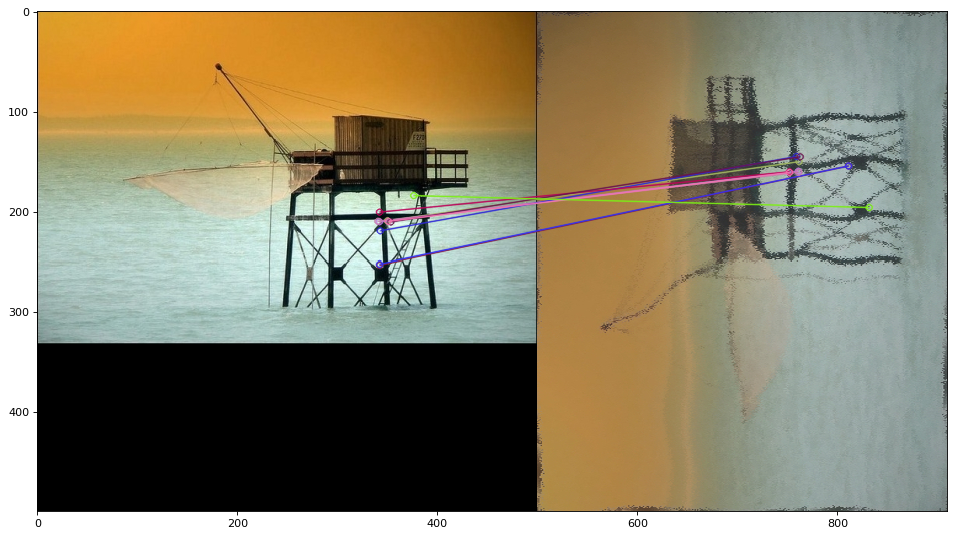

In [12]:
# find the keypoints with ORB
kp2 = orb.detect(red_image_gray_distort, None)
# compute the descriptors with ORB
kp2, des2 = orb.compute(red_image_gray_distort, kp2)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img_match = cv2.drawMatches(red_image,kp1,red_image_distort,
                            kp2,matches[:10], None,flags=2)
plot_cv_utils.plot_cv_img_org(img_match)

### Actividad

Comparar SIFT y ORB buscando en figures/image_match.png las siguientes imágenes: figures/acantilado_color.png
figures/morfo.jpeg
figures/flower.png
figures/building_crop.jpg
figures/logo_ceura.png

Mostrando las imágenes de drawKeypoints(), drawMatches() y el número de matches.